Imports

In [1]:
%matplotlib inline
# Basic
from collections import OrderedDict
from datetime import timedelta
# Numbers
import pandas as pd
import numpy as np
# Graphic
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib import patheffects as pe
import seaborn as sns
# Models
import pmdarima as pm
from arch.univariate import ZeroMean, GARCH, Normal # 3 components of GARCH model
import tensorflow as tf
from tensorflow import keras

Data retrival

In [2]:
# LOAD NAMES
dmkt = "C:/Users/Keegan/OneDrive/1 Studies/2021 - 2022/5003W/3 - Dissertation/5-Data/cleaned/univariate/market_indices/market_names.csv"
mkt_names = pd.read_csv(dmkt).values.tolist()
mkt_names = [item for sublist in mkt_names for item in sublist]

# LOAD DATA
dd = "C:/Users/Keegan/OneDrive/1 Studies/2021 - 2022/5003W/3 - Dissertation/5-Data/cleaned/univariate/market_indices/"
dirs = []
data = OrderedDict()
for i in range(len(mkt_names)):
    # concat strings to get directories
    nm = mkt_names[i]
    directory = dd+nm+".csv"
    # store
    dirs.append(directory)
    data[nm] = pd.read_csv(directory)
    del directory, nm

Constant specifications

In [3]:
# SCALING FACTOR
SCALE = 100
DESCALE = 1/SCALE


# Date parameters
E1 = pd.to_datetime("2020-01-13")
E2 = pd.to_datetime("2020-01-24")
E3 = pd.to_datetime("2020-02-24")
E4 = pd.to_datetime("2020-03-09")

CUT1 = pd.to_datetime("2019-04-29")
CUT2 = pd.to_datetime("2020-06-01")

# Plot parameters
SCATTER = 25
ALPHA = 0.8
LINEWIDTH = 1.5

FONT = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

DATE_FORM  = DateFormatter('%Y-%m-%d')

Notebook Settings

In [4]:
# set data splitting parameters
EVENT = E1

# Toggle Settings
store_stats_results = False
show_plots = False
save_figs = False

# Returns
var_mode = 'log_prices' # alternative = 'log_returns'

# Bounded Scaling
rescale = False

# Plot settings
plt.style.use('seaborn')
plt.rc('font', **FONT)
plt.rc('xtick', labelsize=12)  
plt.rc('ytick', labelsize=12)

Initial Data Wrangling

In [5]:
# select data
MKT = "SPX.Index"
dataset = data[MKT].copy(deep=True)
# format dates
dataset['date'] = pd.to_datetime(dataset['date'].values)
# change colname for ease of use
dataset = dataset.rename(columns={'date':'date', MKT:'val'})
# keep prices for ML
prices = dataset.copy(deep=True)

if var_mode == 'log_returns':
    # extract price level, calc log_returns, store as dataset
    log_returns = np.log(dataset.val.shift(-1) / dataset.val)
    log_returns = log_returns[~np.isnan(log_returns)]

    dataset.val = log_returns
    del log_returns

elif var_mode == 'log_prices':
    # extract price level, calc log_prices, store as dataset
    log_prices = np.log(np.copy(dataset.val.values))
    log_prices = log_prices[~np.isnan(log_prices)]

    dataset.val = log_prices
    del log_prices
else:
    Exception("Variable calculation not specified. Please specify var_mode with one of the following: ['log_returns', 'log_prices']")

# split dataset
Y = dataset.val
X = pd.concat([pd.to_datetime(dataset.date), pd.Series(range(len(Y)))], axis=1).rename({'date':'date',0:'index'},axis=1)
# X_in = X.index[X.date < EVENT]
# X_out = X.index[X.date >= EVENT]
train = dataset[(dataset["date"] < EVENT)] # & (dataset['date'] > pd.to_datetime("2016-01-01")) 
test = dataset[(dataset["date"] >= EVENT)]
# Inspect
print(
    'TABULAR DATA:', '\n',
    'train.shape: ', train.shape, '\n',
    'test.shape: ', test.shape
    )

# retain date seqs
dtrain, dtest = pd.to_datetime(train.date), pd.to_datetime(test.date)
# format structures (and dtypes) for arima
Y, train, test = Y.values, train.val.values, test.val.values
# Inspect and compare
print(
    'DATA VECTORS:', '\n',
    'train.shape: ', train.shape, '\n',
    'test.shape: ', test.shape
    )

TABULAR DATA: 
 train.shape:  (3026, 2) 
 test.shape:  (532, 2)
DATA VECTORS: 
 train.shape:  (3026,) 
 test.shape:  (532,)


Storage Directories for Results

In [6]:
d_model_results = 'C:/Users/Keegan/OneDrive/1 Studies/2021 - 2022/5003W/3 - Dissertation/5-Data/results/fanomal/stats_models/'
d_arima = d_model_results+'arima_results/'+MKT+'/'
d_arima_plots = d_arima+'plots/'
d_garch = d_model_results+'garch_results/'+MKT+'/'
d_garch_plots = d_garch+'plots/'

# Ensure appropriate nested directory exits
from pathlib import Path
Path(d_arima).mkdir(parents=True, exist_ok=True)
Path(d_arima_plots).mkdir(parents=True, exist_ok=True)
Path(d_garch).mkdir(parents=True, exist_ok=True)
Path(d_garch_plots).mkdir(parents=True, exist_ok=True)

ARIMA Modelling

In [7]:
ORDER = (1,1,1)
# construct arima model of order ORDER, keeping data out of sample
arima = pm.ARIMA(order=ORDER, out_of_sample_size=int(test.shape[0]))
fit = arima.fit(Y)
# predict in sample
pred_in = fit.predict_in_sample(start=1, end=Y.shape[0], dynamic=False, return_conf_int=True)
# extract upper & lower confidence intervals of predictions
lw = pd.DataFrame({'date':dataset.date.values, 'lower':[pred_in[1][i][0] for i in range(pred_in[1].shape[0])]}).set_index('date')
up = pd.DataFrame({'date':dataset.date.values, 'upper':[pred_in[1][i][1] for i in range(pred_in[1].shape[0])]}).set_index('date')

In [8]:
# Build pd.DataFrames to make plotting easier
predicted = pd.DataFrame({
    'date':dataset.date.values,
    # 'actual':Y,
    'predicted':pred_in[0],
    'lower':[pred_in[1][i][0] for i in range(pred_in[1].shape[0])],
    'upper':[pred_in[1][i][1] for i in range(pred_in[1].shape[0])]
    }).set_index('date')
train_test = {
    'train':pd.DataFrame({'date':dtrain,'train':train}).set_index('date'),
    'test':pd.DataFrame({'date':dtest,'test':test}).set_index('date')
}
actual = dataset.set_index('date')

ARIMA Plots

In [9]:
MIN_VAL = 1 + 2980
MAX_VAL = MIN_VAL + test.shape[0] - 450
if show_plots:
    # Plot actual test vs. forecasts:
    fig, ax = plt.subplots()
    ax.scatter(
        dataset.date.values[MIN_VAL:MAX_VAL],
        dataset.val.values[MIN_VAL:MAX_VAL],
        marker = '.',
        s = SCATTER,
        alpha = 1,
        color = 'black',
        label = "SP500"
        )
    ax.plot(
        predicted.iloc[MIN_VAL:MAX_VAL],
        alpha = ALPHA,
        linewidth = LINEWIDTH,
        label = predicted.columns
        )

    ax.set_facecolor('whitesmoke')
    ax.fmt_xdata = DATE_FORM
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig.legend(loc=8, ncol=2, prop={'size':15})
    # fig.autofmt_xdate()
    fig.set_size_inches(18.5, 10.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.figure(num=1, figsize=(8,6))
    plt.title('ARIMA(1,1,1) fitted: '+str(MKT), fontsize=20)

    plt.show()
else:
    print("Not showing plot.")

if show_plots & save_figs:
    fig.savefig((d_arima_plots+MKT+'_ARIMA'+str(ORDER)+'_full-fit_CLOSE_UP.png'), dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

Not showing plot.
Not storing plot.


In [10]:
MIN_VAL = 1 + 3000
MAX_VAL = Y.shape[0] - 350
if show_plots:
    fig, ax = plt.subplots()
    ax.scatter(
        dataset.date.values[MIN_VAL:MAX_VAL],
        dataset.val.values[MIN_VAL:MAX_VAL],
        marker = '.',
        s = SCATTER,
        alpha = 1,
        color = 'black',
        label = "SP500"
        )
    ax.plot(
        predicted.iloc[MIN_VAL:MAX_VAL],
        alpha = ALPHA,
        linewidth = LINEWIDTH,
        label = predicted.columns
        )

    ax.set_facecolor('whitesmoke')
    ax.xaxis.set_major_formatter(DATE_FORM)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig.legend(loc=8, ncol=2, prop={'size':15})
    # fig.autofmt_xdate()
    fig.set_size_inches(18.5, 10.5)
    plt.figure(num=1, figsize=(8,6))
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.title('ARIMA(1,1,1) in-sample-predictions: '+str(MKT), fontsize=20)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_arima_plots+'_ARIMA(1,1,1)_IN_SAMPLE_PRED_(close_up).png', dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')
# 

Not showing plot.
Not storing plot.


In [11]:
MIN_VAL = 1 + 2980
MAX_VAL = Y.shape[0] - 350
if show_plots:
    # Plot actual test vs. forecasts:
    fig, ax = plt.subplots()
    ax.scatter(
        dataset.date.values[MIN_VAL:MAX_VAL],
        dataset.val.values[MIN_VAL:MAX_VAL],
        marker = '.',
        s = SCATTER,
        alpha = 1,
        color = 'black',
        label = "SP500"
        )
    ax.plot(
        predicted.iloc[dtrain.shape[0]:MAX_VAL],
        alpha = ALPHA,
        linewidth = LINEWIDTH,
        label = predicted.columns
        )
    ax.plot(
        predicted.iloc[MIN_VAL:dtrain.shape[0]],
        alpha = ALPHA,
        linewidth = LINEWIDTH,
        label = predicted.columns
        )

    ax.set_facecolor('whitesmoke')
    ax.xaxis.set_major_formatter(DATE_FORM)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig.legend(loc=8, ncol=2, prop={'size':15})
    fig.autofmt_xdate()
    fig.set_size_inches(18.5, 10.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.figure(num=1, figsize=(8,6))
    plt.title('ARIMA(1,1,1) fitted: '+str(MKT), fontsize=20)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_arima_plots+'_ARIMA(1,1,1)_full-fit_(close_up).png', dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

Not showing plot.
Not storing plot.


GARCH Modelling

In [12]:
# Specify forecast horizon
H = 10

# Put ARIMA resids into dataframe to make life easier
arima_resids = pd.DataFrame(
    {'date':dataset.date.values[1:], 'arima_resids':fit.resid()[1:]*SCALE},
    copy=True).set_index('date')
# In-sample Model
garch = ZeroMean(arima_resids)
garch.volatility = GARCH(p=ORDER[0],o=1,q=ORDER[2])
garch.distribution = Normal(seed=1)
garch_fit = garch.fit(last_obs = E1)
# Out-sample Analytic Forecasts
f = garch_fit.forecast(horizon = H, start=E1)

# Conditional Volatilities
# 1-period forward forecast conditional volatility
fvol = pd.DataFrame({'date':f.variance['h.01'].index, 'cond_vol':f.variance['h.01'].pow(0.5)}).set_index('date')
# sample estimated conditional volatility
svol = pd.DataFrame({'date':garch_fit.conditional_volatility.index,'cond_vol':garch_fit.conditional_volatility}).set_index('date')
# All conditional volatility from GARCH model
cvol = pd.concat([svol.dropna(), fvol.dropna()])

# Calculate Y_vol
y_vol = pd.DataFrame(
    {'date':dataset.date.values[1:], 'y_vol':fit.resid()[1:]},
    copy=True).set_index('date').multiply(SCALE).pow(2).pow(0.5) #.multiply(SCALE)

# Calculate GARCH residuals
garch_resids = pd.DataFrame({'date':y_vol.index, 'garch_resids':(y_vol.y_vol.values - cvol.cond_vol.values)}).set_index('date')

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1677582420.6263652
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4184.16828721853
Iteration:      3,   Func. Count:     20,   Neg. LLF: 5432.669091828316
Iteration:      4,   Func. Count:     27,   Neg. LLF: 3965.701360839627
Iteration:      5,   Func. Count:     33,   Neg. LLF: 3950.996159779608
Iteration:      6,   Func. Count:     38,   Neg. LLF: 3950.3340404611245
Iteration:      7,   Func. Count:     44,   Neg. LLF: 3949.3412312681403
Iteration:      8,   Func. Count:     50,   Neg. LLF: 3949.1240695788138
Iteration:      9,   Func. Count:     55,   Neg. LLF: 3949.1163030498046
Iteration:     10,   Func. Count:     60,   Neg. LLF: 3949.116293559593
Iteration:     11,   Func. Count:     64,   Neg. LLF: 3949.116293559961
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3949.116293559593
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations

c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


GARCH Plots

In [13]:
if show_plots:
    # Some formatting
    PE = [pe.Stroke(linewidth=3, foreground='black'), pe.Normal()]
    # Plot conditional volatilities
    fig, ax = plt.subplots()
    # ax.plot(garch_fit.conditional_volatility, color='black', label='Full-fit Conditional Volatility')

    ax.plot(y_vol.rolling(window=20).mean(), label='MA(20)', linewidth=1, alpha=0.5, color='violet', zorder=0)

    ax.plot(svol, label='Train Conditional Volatility', linewidth=1, path_effects = PE, zorder=10) #.divide(SCALE).pow(2)
    ax.plot(fvol, label='Forecast Conditional Volatility', linewidth=1, path_effects = PE, zorder=9) #.divide(SCALE).pow(2)
    ax.plot(garch_resids, label='Garch Residuals', alpha=0.3, zorder =2)

    ax.scatter(x=y_vol.index, y=y_vol.values, label='Actual Vol estimate', s=20, alpha=0.5, zorder=1)

    ax.set_facecolor('whitesmoke')
    ax.margins(x=0)
    ax.xaxis.set_major_formatter(DATE_FORM)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig.legend(loc=8, ncol=2, prop={'size':15})
    # fig.autofmt_xdate()
    fig.set_size_inches(18.5, 10.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.figure(num=1, figsize=(8,6))
    plt.title('GARCH(1,1,1) fitted: '+str(MKT), fontsize=20)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_garch_plots+'GRJ-GARCH(1,1,1)_in-sample_vs_out-sample.png', dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

Not showing plot.
Not storing plot.


In [14]:
quiet = svol[svol.index>'2012-01-01']
gfc = svol[svol.index<'2012-01-01']
covid = fvol

In [15]:
if show_plots:
    sns.distplot(arima_resids, color='orange')
    # sns.distplot(garch_fit.resid)
    sns.distplot(garch_resids)
    plt.title('Scaled Model Residuals')
    plt.legend(labels=['ARIMA residuals','GJR-GARCH residuals'])
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_model_results+'ARIMA(1,1,1)_vs_GRJ-GARCH(1,1,1)_residual distributions.png', dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

Not showing plot.
Not storing plot.


STORAGE of Results

In [16]:
# RECORD GARCH RESULTS
# Residuals
if store_stats_results == True:
    garch_resids.to_csv(d_garch+MKT+'_GARCH'+str(ORDER)+'_residuals'+'.csv') 
else:
    print('Not storing'+' GJR-GARCH'+str(ORDER)+' residuals.')

# Extract and store garch model results
# Model characteristics
df_temp = pd.DataFrame(garch_fit.summary().tables[0])
# slice pieces out
tmp1 = df_temp.iloc[0:5,0:2]
tmp2 = df_temp.iloc[0:5,2:4]
tmp3 = df_temp.iloc[6:8,0:2]
tmp4 = df_temp.iloc[5:8,2:4]
# fix colnames
tmp1.columns = ['Item','Value']
tmp2.columns = ['Item','Value']
tmp3.columns = ['Item','Value']
tmp4.columns = ['Item','Value']
# merge and store
if store_stats_results == True:
    pd.concat([tmp1,tmp2,tmp3,tmp4]).set_index('Item').to_csv(d_garch+MKT+' GJR-GARCH'+str(ORDER)+'_characteristics'+'.csv')
    # cleanup
    del df_temp, tmp1, tmp2, tmp3, tmp4
else:
    print('Not storing'+' GJR-GARCH'+str(ORDER)+' characteristics.')
    # cleanup
    del df_temp, tmp1, tmp2, tmp3, tmp4

# Model parameters
df_temp = pd.DataFrame(garch_fit.summary().tables[1])
# restructure & store
df_temp.columns = df_temp.iloc[0]
tmp_cols = ['name']
[tmp_cols.append(str(n)) for n in list(df_temp.columns)[1:]]
df_temp.columns = tmp_cols
if store_stats_results == True:
    df_temp.drop(0).set_index('name').to_csv(d_garch+MKT+'_GJR-GARCH'+str(ORDER)+'_model_params'+'.csv')
    # cleanup
    del df_temp, tmp_cols
else:
    print('Not storing'+' GJR-GARCH'+str(ORDER)+' model params.')
    # cleanup
    del df_temp, tmp_cols

######################
# RECORD ARIMA RESULTS
# Residuals
if store_stats_results == True:
    arima_resids.to_csv(d_arima+MKT+'_ARIMA'+str(ORDER)+'_residuals'+'.csv')
else:
    print('Not storing'+' ARIMA'+str(ORDER)+' residuals.')

# Extract and store garch model results
# Model characteristics
df_temp = pd.DataFrame(fit.summary().tables[0])
nobs = int(str(df_temp.iloc[5,1]).replace(" ",""))
# slice unruly pieces out
tmp1 = df_temp[[0,1]]
tmp2 = df_temp[[2,3]].drop([5,6],axis=0).rename({2:0,3:1},axis=1)
# wrangle
df_temp = pd.concat([tmp1,tmp2])
df_temp.index = range(len(df_temp))
df_temp = df_temp.drop(5, axis=0)
df_temp.index = range(len(df_temp))
df_temp.iloc[4,1]=tuple([0, nobs])
df_temp.iloc[0:1,1:2] = MKT
df_temp = df_temp.rename({0:'Item',1:'Value'}, axis=1).set_index('Item')
if store_stats_results == True:
    df_temp.to_csv(d_arima+MKT+'_ARIMA'+str(ORDER)+'_characteristics'+'.csv')
    # cleanup
    del df_temp, tmp1, tmp2
else:
    print('Not storing'+' ARIMA'+str(ORDER)+' characteristics.')
    # cleanup
    del df_temp, tmp1, tmp2

# ARIMA Model coefs & sigs
df_temp = pd.DataFrame(fit.summary().tables[1])
# restructure & store
df_temp.columns = df_temp.iloc[0]
tmp_cols = ['name']
[tmp_cols.append(str(n)) for n in list(df_temp.columns)[1:]]
df_temp.columns = tmp_cols
if store_stats_results == True:
    df_temp.drop(0).set_index('name').to_csv(d_arima+MKT+'_ARIMA'+str(ORDER)+'_model_params'+'.csv')
    # cleanup
    del df_temp, tmp_cols
else:
    print('Not storing'+' ARIMA'+str(ORDER)+' model params.')
    # cleanup
    del df_temp, tmp_cols

# ARIMA statistics
df_temp = pd.DataFrame(fit.summary().tables[2])
tmp1 = df_temp[[0,1]]
tmp2 = df_temp[[2,3]].rename({2:0,3:1},axis=1)
if store_stats_results == True:
    pd.concat([tmp1,tmp2]).rename({0:'Statistic',1:'Value'}, axis=1).set_index('Statistic').to_csv(d_arima+MKT+'_ARIMA'+str(ORDER)+'_statistics'+'.csv')
    # cleanup
    del df_temp, tmp1, tmp2
else:
    print('Not storing'+' ARIMA'+str(ORDER)+' statistics.')
    # cleanup
    del df_temp, tmp1, tmp2

Not storing GJR-GARCH(1, 1, 1) residuals.
Not storing GJR-GARCH(1, 1, 1) characteristics.
Not storing GJR-GARCH(1, 1, 1) model params.
Not storing ARIMA(1, 1, 1) residuals.
Not storing ARIMA(1, 1, 1) characteristics.
Not storing ARIMA(1, 1, 1) model params.
Not storing ARIMA(1, 1, 1) statistics.


######################

AutoEncoder Prep

Funcs for data preprocessing

In [17]:
def bounded_scaler(vec,k=[-1,1], scale=True, MIN_MAX = None, SCALE_PARAMS = None):
    MAX = np.max(vec)
    MIN = np.min(vec)
    RANGE = MAX - MIN
    MULT = k[1] - k[0] # mult = b - a

    scale_params = {'min':MIN, 'max':MAX,'range':RANGE, 'b-a':MULT}
    if vec.ndim ==2:
        vec = vec.reshape(vec.shape[0])

    if scale:
        scaled_vec = np.subtract(np.multiply(np.divide(np.subtract(vec,MIN), RANGE), MULT), 1)
        return scaled_vec, scale_params
    elif MIN_MAX:
        if (isinstance(MIN_MAX,dict) == False):
            raise TypeError("MIN_MAX must be an object of dictionary class")
        else:
            RANGE = MIN_MAX['max'] - MIN_MAX['min']
            frac = np.divide(RANGE, MULT)
            unscaled_vec = np.add(np.multiply(np.subtract(vec, k[0]), frac), MIN_MAX['min'])
            del frac
            return unscaled_vec
    elif SCALE_PARAMS:
        if (isinstance(SCALE_PARAMS,dict) == False):
            raise TypeError("SCALE_PARAMS must be an object of dictionary class")
        else:
            frac = np.divide(SCALE_PARAMS['range'], MULT)
            unscaled_vec = np.add(np.multiply(np.subtract(vec, k[0]), frac), SCALE_PARAMS['min'])
            del frac
            return unscaled_vec
    else:
        raise ValueError("I don't know what you want me to do man. Check inputs.")


In [18]:
def lagged_df(series, lags=32, nans=False, scale=None):
    dct = OrderedDict()
    dct['date'] = series.index.values #.reshape(len(train.index),1)
    if scale==None:
        for i in range(lags):
            if i ==0:
                dct['l'+str(i)] = series.values.reshape(len(series),)
            else:
                dct['l'+str(i)] = series.shift(i).values.reshape(len(series),)
    else:
        for i in range(lags):
            if i ==0:
                dct['l'+str(i)] = np.multiply(series.values.reshape(len(series),),scale)
            else:
                dct['l'+str(i)] = np.multiply(series.shift(i).values.reshape(len(series),),scale)
    if nans:
        df = pd.DataFrame(dct).set_index('date')
    else:
        df = pd.DataFrame(dct).set_index('date').dropna()

    return df

In [22]:
print(
    'testing of results \n',
    all(garch_fit.resid.values == arima_resids.arima_resids.values), '\n',
    all(garch_resids.garch_resids.values == arima_resids.arima_resids.values), '\n',
    all(garch_resids.garch_resids.values == garch_fit.resid.values)
)

testing of results 
 False 
 False 
 False


ARIMA resid features

In [69]:
# specify AE's train and test data
train, test = arima_resids[(arima_resids.index < EVENT)], arima_resids[(arima_resids.index >= EVENT)]
train_dates, test_dates = train.index, test.index

# unscale data
train, test = np.multiply(train, DESCALE), np.multiply(test, DESCALE)

if rescale:
    # Rescale to be between [-1,1]
    train, test = bounded_scaler(train.values)[0], bounded_scaler(test.values)[0]
    # convert to datetime indexed dataframes
    train, test = pd.DataFrame({'date':train_dates, 'data':train.reshape(len(train))}).set_index('date'), pd.DataFrame({'date':test_dates, 'data':test.reshape(len(test))}).set_index('date')
else:
    print('Not scaling according to bounds.')
x_train, x_test = lagged_df(train, lags=32), lagged_df(test, lags=32) #  scale=DESCALE 

# Examine dims
print('train shape',train.shape,'\n test shape:',test.shape,'\n long sum:',(train.shape[0]+test.shape[0],test.shape[1]))
print('x train shape: ', x_train.shape, '\n x test shape: ', x_test.shape)
x_train['l0'].describe()

WandB Tracking & callbacks

In [73]:
# Tracking & callbacks
import wandb
from wandb.keras import WandbCallback

run = wandb.init(
    project='anomal',
    entity='keegangclarke',
    save_code=True,
    reinit=True,
    mode='online', # options are ['online', 'offline', 'disabled']
)
config = run.config

# length of data that will be used to create training dataset
config.train_data = 0.75
config.epochs = 1000
config.validation_split = 1 - config.train_data

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▇▆▆▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▆▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
GFLOPs,0.0
best_epoch,105
best_val_loss,0.01094
epoch,115
loss,0.02225
val_loss,0.01104


AutoEncoder Specification

DENSE

In [74]:
# Allows changes to model struct
# config.update(allow_val_change=True)
CHANGE = 2

# model specification
config.Lio, config.L2, config.L3, config.Lm = [32, 24, 16, 8] # config.L4, config.L5, config.L6, config.L7, config.L8,
config.act1, config.act2, config.actM, config.actF = ['tanh','tanh','tanh','tanh']
#learning params
config.batch =  384
config.initial = tf.keras.initializers.GlorotNormal()

In [75]:
# Autoencoder
model = keras.Sequential(
    [   
        keras.layers.Flatten(input_shape=(x_train.shape[1],)
        ),
        keras.layers.Dense(
                    config.Lio, activation=config.act1, #kernel_regularizer='l1'
        ),
        keras.layers.Dense(
                    config.L2, activation=config.act1, #kernel_regularizer='l1'
        ),
        keras.layers.Dense(
                    config.L3, activation=config.act1, #kernel_regularizer='l1'
        ),
        keras.layers.Dense(
                    config.Lm, activation=config.actM, #kernel_regularizer='l1',
                    kernel_initializer='lecun_normal'
        ),
        keras.layers.Dense(
                    config.L3, activation=config.act2, #kernel_regularizer='l1'
        ),
        keras.layers.Dense(
                    config.L2, activation=config.act2, #kernel_regularizer='l1'
        ),
        keras.layers.Dense(
                    config.Lio, activation=config.actF, #kernel_regularizer='l1'
        ),
        keras.layers.Reshape((x_train.shape[1],)
        ),
    ]
)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 24)                792       
                                                                 
 dense_9 (Dense)             (None, 16)                400       
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 16)                144       
                                                                 
 dense_12 (Dense)            (None, 24)               

In [76]:
# x_train = x_train.reshape(x_train.shape[0],x_train.shape[2],x_train.shape[1])

RNN

In [77]:
# # Allows changes to model struct
# # config.update(allow_val_change=True)
# CHANGE = 2

# # model specification
# config.Lio, config.L2, config.L3, config.Lm = [72, 54, 36, 18] # config.L4, config.L5, config.L6, config.L7, config.L8,
# config.act1, config.act2, config.actM, config.actF = ['tanh','tanh','tanh','tanh']
# #learning params
# config.batch =  128
# config.initial = tf.keras.initializers.GlorotNormal()

In [78]:
# # RRN Autoencoder
# model = keras.Sequential(
#     [   
#         # keras.layers.Flatten(input_shape=(6,12)
#         # ),
#         keras.layers.SimpleRNN(
#                     config.Lio, activation=config.act1, kernel_regularizer='l1', return_sequences=True,
#                     input_shape=(6,12)
#         ),
#         keras.layers.Dropout(rate=0.2),
#         keras.layers.SimpleRNN(
#                     config.L2, activation=config.act1, kernel_regularizer='l1', return_sequences=True
#         ),
#         keras.layers.SimpleRNN(
#                     config.L3, activation=config.act1, kernel_regularizer='l1', return_sequences=True
#         ),
#         keras.layers.SimpleRNN(
#                     config.Lm, activation=config.actM, kernel_regularizer='l1', return_sequences=True,
#                     kernel_initializer='lecun_normal'
#         ),
#         keras.layers.SimpleRNN(
#                     config.L3, activation=config.act2, kernel_regularizer='l1', return_sequences=True
#         ),
#         keras.layers.SimpleRNN(
#                     config.L2, activation=config.act2, kernel_regularizer='l1', return_sequences=True
#         ),
#         keras.layers.Dropout(rate=0.2),
#         keras.layers.SimpleRNN(
#                     config.Lio, activation=config.actF, kernel_regularizer='l1', return_sequences=True
#         ),
#         keras.layers.Reshape((6,12)
#         ),
#     ]
# )
# model.compile(optimizer='adam', loss='mse')
# # model.summary()

Fit AE

In [79]:
# fit AE
history = model.fit(
    x=x_train, 
    y=x_train,
    batch_size=config.batch,
    epochs=config.epochs,
    validation_split=config.validation_split,
    shuffle=False,
    callbacks=[
        WandbCallback(),
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            mode='min'
            )
    ]
)

Epoch 1/1000
1/6 [====>.........................] - ETA: 1s - loss: 0.0016INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 295ms/step - loss: 5.2150e-04 - val_loss: 1.8176e-04
Epoch 2/1000
1/6 [====>.........................] - ETA: 0s - loss: 0.0013INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 4s 848ms/step - loss: 3.6449e-04 - val_loss: 1.3381e-04
Epoch 3/1000
1/6 [====>.........................] - ETA: 0s - loss: 9.4163e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 361ms/step - loss: 2.8907e-04 - val_loss: 9.5731e-05
Epoch 4/1000
1/6 [====>.........................] - ETA: 0s - loss: 8.3078e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 285ms/step - loss: 2.5204e-04 - val_loss: 8.6276e-05
Epoch 5/1000
1/6 [====>.........................] - ETA: 0s - loss: 7.5467e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 335ms/step - loss: 2.2867e-04 - val_loss: 8.1778e-05
Epoch 6/1000
1/6 [====>.........................] - ETA: 0s - loss: 6.9556e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 292ms/step - loss: 2.1389e-04 - val_loss: 7.5513e-05
Epoch 7/1000
1/6 [====>.........................] - ETA: 0s - loss: 6.6291e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 283ms/step - loss: 2.0309e-04 - val_loss: 7.2824e-05
Epoch 8/1000
1/6 [====>.........................] - ETA: 0s - loss: 6.3910e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 324ms/step - loss: 1.9589e-04 - val_loss: 7.0644e-05
Epoch 9/1000
1/6 [====>.........................] - ETA: 0s - loss: 6.1695e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 320ms/step - loss: 1.8999e-04 - val_loss: 6.8843e-05
Epoch 10/1000
1/6 [====>.........................] - ETA: 0s - loss: 6.0058e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 282ms/step - loss: 1.8514e-04 - val_loss: 6.7176e-05
Epoch 11/1000
1/6 [====>.........................] - ETA: 0s - loss: 5.8784e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 318ms/step - loss: 1.8130e-04 - val_loss: 6.5938e-05
Epoch 12/1000
1/6 [====>.........................] - ETA: 0s - loss: 5.7581e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 289ms/step - loss: 1.7789e-04 - val_loss: 6.4872e-05
Epoch 13/1000
1/6 [====>.........................] - ETA: 0s - loss: 5.6548e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 286ms/step - loss: 1.7487e-04 - val_loss: 6.3864e-05
Epoch 14/1000
1/6 [====>.........................] - ETA: 0s - loss: 5.5644e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 302ms/step - loss: 1.7221e-04 - val_loss: 6.2973e-05
Epoch 15/1000
1/6 [====>.........................] - ETA: 0s - loss: 5.4816e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 286ms/step - loss: 1.6979e-04 - val_loss: 6.2164e-05
Epoch 16/1000
1/6 [====>.........................] - ETA: 0s - loss: 5.4059e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 284ms/step - loss: 1.6758e-04 - val_loss: 6.1419e-05
Epoch 17/1000
1/6 [====>.........................] - ETA: 0s - loss: 5.3358e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 374ms/step - loss: 1.6554e-04 - val_loss: 6.0721e-05
Epoch 18/1000
1/6 [====>.........................] - ETA: 0s - loss: 5.2721e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 300ms/step - loss: 1.6366e-04 - val_loss: 6.0080e-05
Epoch 19/1000
1/6 [====>.........................] - ETA: 0s - loss: 5.2125e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 282ms/step - loss: 1.6192e-04 - val_loss: 5.9486e-05
Epoch 20/1000
1/6 [====>.........................] - ETA: 0s - loss: 5.1572e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 271ms/step - loss: 1.6031e-04 - val_loss: 5.8929e-05
Epoch 21/1000
1/6 [====>.........................] - ETA: 0s - loss: 5.1060e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 305ms/step - loss: 1.5881e-04 - val_loss: 5.8414e-05
Epoch 22/1000
1/6 [====>.........................] - ETA: 0s - loss: 5.0582e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 290ms/step - loss: 1.5742e-04 - val_loss: 5.7934e-05
Epoch 23/1000
1/6 [====>.........................] - ETA: 0s - loss: 5.0136e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 291ms/step - loss: 1.5612e-04 - val_loss: 5.7487e-05
Epoch 24/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.9720e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 305ms/step - loss: 1.5492e-04 - val_loss: 5.7071e-05
Epoch 25/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.9330e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 350ms/step - loss: 1.5379e-04 - val_loss: 5.6683e-05
Epoch 26/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.8965e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 304ms/step - loss: 1.5274e-04 - val_loss: 5.6321e-05
Epoch 27/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.8621e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 276ms/step - loss: 1.5176e-04 - val_loss: 5.5983e-05
Epoch 28/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.8296e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 370ms/step - loss: 1.5084e-04 - val_loss: 5.5667e-05
Epoch 29/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.7990e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 303ms/step - loss: 1.4997e-04 - val_loss: 5.5371e-05
Epoch 30/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.7700e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 326ms/step - loss: 1.4916e-04 - val_loss: 5.5094e-05
Epoch 31/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.7424e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 305ms/step - loss: 1.4839e-04 - val_loss: 5.4834e-05
Epoch 32/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.7163e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 300ms/step - loss: 1.4767e-04 - val_loss: 5.4591e-05
Epoch 33/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.6915e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 293ms/step - loss: 1.4699e-04 - val_loss: 5.4363e-05
Epoch 34/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.6680e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 294ms/step - loss: 1.4635e-04 - val_loss: 5.4149e-05
Epoch 35/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.6456e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 282ms/step - loss: 1.4574e-04 - val_loss: 5.3948e-05
Epoch 36/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.6243e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 301ms/step - loss: 1.4517e-04 - val_loss: 5.3759e-05
Epoch 37/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.6040e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 282ms/step - loss: 1.4463e-04 - val_loss: 5.3581e-05
Epoch 38/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.5847e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 303ms/step - loss: 1.4412e-04 - val_loss: 5.3412e-05
Epoch 39/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.5662e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 283ms/step - loss: 1.4363e-04 - val_loss: 5.3251e-05
Epoch 40/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.5486e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 370ms/step - loss: 1.4316e-04 - val_loss: 5.3098e-05
Epoch 41/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.5316e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 471ms/step - loss: 1.4271e-04 - val_loss: 5.2951e-05
Epoch 42/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.5151e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 289ms/step - loss: 1.4228e-04 - val_loss: 5.2808e-05
Epoch 43/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.4992e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 292ms/step - loss: 1.4186e-04 - val_loss: 5.2670e-05
Epoch 44/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.4837e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 285ms/step - loss: 1.4145e-04 - val_loss: 5.2535e-05
Epoch 45/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.4686e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 465ms/step - loss: 1.4105e-04 - val_loss: 5.2403e-05
Epoch 46/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.4537e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 289ms/step - loss: 1.4065e-04 - val_loss: 5.2272e-05
Epoch 47/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.4390e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 296ms/step - loss: 1.4026e-04 - val_loss: 5.2143e-05
Epoch 48/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.4245e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 299ms/step - loss: 1.3987e-04 - val_loss: 5.2016e-05
Epoch 49/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.4101e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 454ms/step - loss: 1.3949e-04 - val_loss: 5.1889e-05
Epoch 50/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.3958e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 282ms/step - loss: 1.3911e-04 - val_loss: 5.1763e-05
Epoch 51/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.3815e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 328ms/step - loss: 1.3873e-04 - val_loss: 5.1638e-05
Epoch 52/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.3674e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 421ms/step - loss: 1.3835e-04 - val_loss: 5.1514e-05
Epoch 53/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.3534e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 389ms/step - loss: 1.3797e-04 - val_loss: 5.1390e-05
Epoch 54/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.3394e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 349ms/step - loss: 1.3759e-04 - val_loss: 5.1266e-05
Epoch 55/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.3255e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 322ms/step - loss: 1.3722e-04 - val_loss: 5.1144e-05
Epoch 56/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.3118e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 392ms/step - loss: 1.3685e-04 - val_loss: 5.1022e-05
Epoch 57/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.2981e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 323ms/step - loss: 1.3648e-04 - val_loss: 5.0901e-05
Epoch 58/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.2846e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 291ms/step - loss: 1.3612e-04 - val_loss: 5.0780e-05
Epoch 59/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.2713e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 298ms/step - loss: 1.3575e-04 - val_loss: 5.0660e-05
Epoch 60/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.2581e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 317ms/step - loss: 1.3540e-04 - val_loss: 5.0542e-05
Epoch 61/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.2450e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 333ms/step - loss: 1.3504e-04 - val_loss: 5.0424e-05
Epoch 62/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.2321e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 326ms/step - loss: 1.3469e-04 - val_loss: 5.0307e-05
Epoch 63/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.2194e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 386ms/step - loss: 1.3434e-04 - val_loss: 5.0192e-05
Epoch 64/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.2070e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 395ms/step - loss: 1.3400e-04 - val_loss: 5.0079e-05
Epoch 65/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.1948e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 408ms/step - loss: 1.3367e-04 - val_loss: 4.9970e-05
Epoch 66/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.1829e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 380ms/step - loss: 1.3335e-04 - val_loss: 4.9863e-05
Epoch 67/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.1713e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 382ms/step - loss: 1.3303e-04 - val_loss: 4.9761e-05
Epoch 68/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.1601e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 358ms/step - loss: 1.3273e-04 - val_loss: 4.9664e-05
Epoch 69/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.1494e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 383ms/step - loss: 1.3244e-04 - val_loss: 4.9572e-05
Epoch 70/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.1391e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 402ms/step - loss: 1.3217e-04 - val_loss: 4.9487e-05
Epoch 71/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.1294e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 380ms/step - loss: 1.3191e-04 - val_loss: 4.9409e-05
Epoch 72/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.1202e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 370ms/step - loss: 1.3167e-04 - val_loss: 4.9337e-05
Epoch 73/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.1116e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 424ms/step - loss: 1.3145e-04 - val_loss: 4.9272e-05
Epoch 74/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.1036e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 418ms/step - loss: 1.3125e-04 - val_loss: 4.9214e-05
Epoch 75/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.0961e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 376ms/step - loss: 1.3106e-04 - val_loss: 4.9162e-05
Epoch 76/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.0891e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 520ms/step - loss: 1.3089e-04 - val_loss: 4.9116e-05
Epoch 77/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.0825e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 404ms/step - loss: 1.3073e-04 - val_loss: 4.9075e-05
Epoch 78/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.0764e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 422ms/step - loss: 1.3059e-04 - val_loss: 4.9038e-05
Epoch 79/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.0707e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 399ms/step - loss: 1.3045e-04 - val_loss: 4.9005e-05
Epoch 80/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.0652e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 398ms/step - loss: 1.3033e-04 - val_loss: 4.8975e-05
Epoch 81/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.0600e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 349ms/step - loss: 1.3021e-04 - val_loss: 4.8948e-05
Epoch 82/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.0551e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 275ms/step - loss: 1.3010e-04 - val_loss: 4.8924e-05
Epoch 83/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.0503e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 344ms/step - loss: 1.2999e-04 - val_loss: 4.8902e-05
Epoch 84/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.0457e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 396ms/step - loss: 1.2989e-04 - val_loss: 4.8881e-05
Epoch 85/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.0413e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 296ms/step - loss: 1.2980e-04 - val_loss: 4.8862e-05
Epoch 86/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.0370e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 313ms/step - loss: 1.2970e-04 - val_loss: 4.8845e-05
Epoch 87/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.0328e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 307ms/step - loss: 1.2961e-04 - val_loss: 4.8828e-05
Epoch 88/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.0286e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 345ms/step - loss: 1.2952e-04 - val_loss: 4.8812e-05
Epoch 89/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.0246e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 277ms/step - loss: 1.2944e-04 - val_loss: 4.8797e-05
Epoch 90/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.0207e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 268ms/step - loss: 1.2935e-04 - val_loss: 4.8783e-05
Epoch 91/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.0168e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 278ms/step - loss: 1.2927e-04 - val_loss: 4.8770e-05
Epoch 92/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.0130e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 265ms/step - loss: 1.2919e-04 - val_loss: 4.8757e-05
Epoch 93/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.0092e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 275ms/step - loss: 1.2911e-04 - val_loss: 4.8744e-05
Epoch 94/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.0055e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 269ms/step - loss: 1.2904e-04 - val_loss: 4.8732e-05
Epoch 95/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.0019e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 272ms/step - loss: 1.2896e-04 - val_loss: 4.8720e-05
Epoch 96/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9983e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 275ms/step - loss: 1.2888e-04 - val_loss: 4.8708e-05
Epoch 97/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9948e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 278ms/step - loss: 1.2881e-04 - val_loss: 4.8697e-05
Epoch 98/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9913e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 357ms/step - loss: 1.2874e-04 - val_loss: 4.8686e-05
Epoch 99/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9878e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 367ms/step - loss: 1.2866e-04 - val_loss: 4.8675e-05
Epoch 100/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9844e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 267ms/step - loss: 1.2859e-04 - val_loss: 4.8664e-05
Epoch 101/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9811e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 270ms/step - loss: 1.2852e-04 - val_loss: 4.8654e-05
Epoch 102/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9778e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 321ms/step - loss: 1.2845e-04 - val_loss: 4.8643e-05
Epoch 103/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9746e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 288ms/step - loss: 1.2838e-04 - val_loss: 4.8633e-05
Epoch 104/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9714e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 284ms/step - loss: 1.2832e-04 - val_loss: 4.8623e-05
Epoch 105/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9682e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 284ms/step - loss: 1.2825e-04 - val_loss: 4.8613e-05
Epoch 106/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9651e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 282ms/step - loss: 1.2818e-04 - val_loss: 4.8603e-05
Epoch 107/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9620e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 601ms/step - loss: 1.2812e-04 - val_loss: 4.8593e-05
Epoch 108/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9590e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 277ms/step - loss: 1.2805e-04 - val_loss: 4.8583e-05
Epoch 109/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9560e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 306ms/step - loss: 1.2799e-04 - val_loss: 4.8573e-05
Epoch 110/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9530e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 297ms/step - loss: 1.2792e-04 - val_loss: 4.8564e-05
Epoch 111/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9501e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 351ms/step - loss: 1.2786e-04 - val_loss: 4.8554e-05
Epoch 112/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9473e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 272ms/step - loss: 1.2780e-04 - val_loss: 4.8545e-05
Epoch 113/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9445e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 266ms/step - loss: 1.2774e-04 - val_loss: 4.8535e-05
Epoch 114/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9417e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 282ms/step - loss: 1.2768e-04 - val_loss: 4.8526e-05
Epoch 115/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9390e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 279ms/step - loss: 1.2762e-04 - val_loss: 4.8517e-05
Epoch 116/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9363e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 271ms/step - loss: 1.2756e-04 - val_loss: 4.8507e-05
Epoch 117/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9337e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 273ms/step - loss: 1.2750e-04 - val_loss: 4.8498e-05
Epoch 118/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9311e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 303ms/step - loss: 1.2744e-04 - val_loss: 4.8489e-05
Epoch 119/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9285e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 301ms/step - loss: 1.2738e-04 - val_loss: 4.8480e-05
Epoch 120/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9260e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 283ms/step - loss: 1.2733e-04 - val_loss: 4.8471e-05
Epoch 121/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9235e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 273ms/step - loss: 1.2727e-04 - val_loss: 4.8462e-05
Epoch 122/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9211e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 311ms/step - loss: 1.2722e-04 - val_loss: 4.8453e-05
Epoch 123/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9187e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 380ms/step - loss: 1.2716e-04 - val_loss: 4.8444e-05
Epoch 124/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9164e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 304ms/step - loss: 1.2711e-04 - val_loss: 4.8435e-05
Epoch 125/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9141e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 280ms/step - loss: 1.2706e-04 - val_loss: 4.8426e-05
Epoch 126/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9118e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 296ms/step - loss: 1.2700e-04 - val_loss: 4.8418e-05
Epoch 127/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9096e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 293ms/step - loss: 1.2695e-04 - val_loss: 4.8409e-05
Epoch 128/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9074e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 463ms/step - loss: 1.2690e-04 - val_loss: 4.8400e-05
Epoch 129/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9053e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 411ms/step - loss: 1.2685e-04 - val_loss: 4.8392e-05
Epoch 130/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9032e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 324ms/step - loss: 1.2680e-04 - val_loss: 4.8383e-05
Epoch 131/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.9011e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 282ms/step - loss: 1.2676e-04 - val_loss: 4.8375e-05
Epoch 132/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8991e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 314ms/step - loss: 1.2671e-04 - val_loss: 4.8366e-05
Epoch 133/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8971e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 359ms/step - loss: 1.2666e-04 - val_loss: 4.8358e-05
Epoch 134/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8952e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 663ms/step - loss: 1.2662e-04 - val_loss: 4.8349e-05
Epoch 135/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8932e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 350ms/step - loss: 1.2657e-04 - val_loss: 4.8341e-05
Epoch 136/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8914e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 283ms/step - loss: 1.2653e-04 - val_loss: 4.8333e-05
Epoch 137/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8895e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 299ms/step - loss: 1.2648e-04 - val_loss: 4.8324e-05
Epoch 138/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8877e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 328ms/step - loss: 1.2644e-04 - val_loss: 4.8316e-05
Epoch 139/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8860e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 352ms/step - loss: 1.2639e-04 - val_loss: 4.8308e-05
Epoch 140/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8842e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 314ms/step - loss: 1.2635e-04 - val_loss: 4.8299e-05
Epoch 141/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8825e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 298ms/step - loss: 1.2631e-04 - val_loss: 4.8291e-05
Epoch 142/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8809e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 292ms/step - loss: 1.2627e-04 - val_loss: 4.8283e-05
Epoch 143/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8792e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 279ms/step - loss: 1.2623e-04 - val_loss: 4.8275e-05
Epoch 144/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8776e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 308ms/step - loss: 1.2619e-04 - val_loss: 4.8267e-05
Epoch 145/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8761e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 316ms/step - loss: 1.2615e-04 - val_loss: 4.8259e-05
Epoch 146/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8745e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 328ms/step - loss: 1.2611e-04 - val_loss: 4.8251e-05
Epoch 147/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8730e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 518ms/step - loss: 1.2607e-04 - val_loss: 4.8243e-05
Epoch 148/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8715e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 297ms/step - loss: 1.2604e-04 - val_loss: 4.8235e-05
Epoch 149/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8701e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 293ms/step - loss: 1.2600e-04 - val_loss: 4.8227e-05
Epoch 150/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8687e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 308ms/step - loss: 1.2596e-04 - val_loss: 4.8220e-05
Epoch 151/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8673e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 327ms/step - loss: 1.2593e-04 - val_loss: 4.8212e-05
Epoch 152/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8659e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 289ms/step - loss: 1.2589e-04 - val_loss: 4.8205e-05
Epoch 153/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8646e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 303ms/step - loss: 1.2586e-04 - val_loss: 4.8197e-05
Epoch 154/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8633e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 281ms/step - loss: 1.2582e-04 - val_loss: 4.8190e-05
Epoch 155/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8620e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 301ms/step - loss: 1.2579e-04 - val_loss: 4.8183e-05
Epoch 156/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8608e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 271ms/step - loss: 1.2576e-04 - val_loss: 4.8175e-05
Epoch 157/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8596e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 253ms/step - loss: 1.2573e-04 - val_loss: 4.8168e-05
Epoch 158/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8584e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 351ms/step - loss: 1.2569e-04 - val_loss: 4.8161e-05
Epoch 159/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8572e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 481ms/step - loss: 1.2566e-04 - val_loss: 4.8154e-05
Epoch 160/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8561e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 288ms/step - loss: 1.2563e-04 - val_loss: 4.8148e-05
Epoch 161/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8550e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 284ms/step - loss: 1.2560e-04 - val_loss: 4.8141e-05
Epoch 162/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8539e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 305ms/step - loss: 1.2557e-04 - val_loss: 4.8134e-05
Epoch 163/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8528e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 285ms/step - loss: 1.2554e-04 - val_loss: 4.8128e-05
Epoch 164/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8517e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 326ms/step - loss: 1.2551e-04 - val_loss: 4.8122e-05
Epoch 165/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8507e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 318ms/step - loss: 1.2548e-04 - val_loss: 4.8116e-05
Epoch 166/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8497e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 297ms/step - loss: 1.2545e-04 - val_loss: 4.8109e-05
Epoch 167/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8487e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 302ms/step - loss: 1.2543e-04 - val_loss: 4.8103e-05
Epoch 168/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8478e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 256ms/step - loss: 1.2540e-04 - val_loss: 4.8098e-05
Epoch 169/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8468e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 318ms/step - loss: 1.2537e-04 - val_loss: 4.8092e-05
Epoch 170/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8459e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 360ms/step - loss: 1.2534e-04 - val_loss: 4.8086e-05
Epoch 171/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8450e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 414ms/step - loss: 1.2532e-04 - val_loss: 4.8080e-05
Epoch 172/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8441e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 292ms/step - loss: 1.2529e-04 - val_loss: 4.8075e-05
Epoch 173/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8433e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 283ms/step - loss: 1.2527e-04 - val_loss: 4.8070e-05
Epoch 174/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8424e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 328ms/step - loss: 1.2524e-04 - val_loss: 4.8064e-05
Epoch 175/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8416e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 301ms/step - loss: 1.2522e-04 - val_loss: 4.8059e-05
Epoch 176/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8408e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 369ms/step - loss: 1.2519e-04 - val_loss: 4.8054e-05
Epoch 177/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8400e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 305ms/step - loss: 1.2517e-04 - val_loss: 4.8048e-05
Epoch 178/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8392e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 277ms/step - loss: 1.2514e-04 - val_loss: 4.8043e-05
Epoch 179/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8385e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 316ms/step - loss: 1.2512e-04 - val_loss: 4.8038e-05
Epoch 180/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8377e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 324ms/step - loss: 1.2510e-04 - val_loss: 4.8033e-05
Epoch 181/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8370e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 298ms/step - loss: 1.2507e-04 - val_loss: 4.8028e-05
Epoch 182/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8363e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 421ms/step - loss: 1.2505e-04 - val_loss: 4.8023e-05
Epoch 183/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8356e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 283ms/step - loss: 1.2503e-04 - val_loss: 4.8019e-05
Epoch 184/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8349e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 283ms/step - loss: 1.2501e-04 - val_loss: 4.8014e-05
Epoch 185/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8343e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 278ms/step - loss: 1.2498e-04 - val_loss: 4.8009e-05
Epoch 186/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8336e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 304ms/step - loss: 1.2496e-04 - val_loss: 4.8004e-05
Epoch 187/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8330e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 313ms/step - loss: 1.2494e-04 - val_loss: 4.7999e-05
Epoch 188/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8323e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 338ms/step - loss: 1.2492e-04 - val_loss: 4.7994e-05
Epoch 189/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8317e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 363ms/step - loss: 1.2490e-04 - val_loss: 4.7989e-05
Epoch 190/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8311e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 309ms/step - loss: 1.2488e-04 - val_loss: 4.7985e-05
Epoch 191/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8305e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 382ms/step - loss: 1.2486e-04 - val_loss: 4.7980e-05
Epoch 192/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8300e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 326ms/step - loss: 1.2484e-04 - val_loss: 4.7975e-05
Epoch 193/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8294e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 303ms/step - loss: 1.2482e-04 - val_loss: 4.7970e-05
Epoch 194/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8288e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 421ms/step - loss: 1.2480e-04 - val_loss: 4.7965e-05
Epoch 195/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8283e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 563ms/step - loss: 1.2478e-04 - val_loss: 4.7960e-05
Epoch 196/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8278e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 608ms/step - loss: 1.2476e-04 - val_loss: 4.7956e-05
Epoch 197/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8272e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 568ms/step - loss: 1.2474e-04 - val_loss: 4.7951e-05
Epoch 198/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8267e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 558ms/step - loss: 1.2472e-04 - val_loss: 4.7946e-05
Epoch 199/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8262e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 611ms/step - loss: 1.2471e-04 - val_loss: 4.7941e-05
Epoch 200/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8257e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 601ms/step - loss: 1.2469e-04 - val_loss: 4.7936e-05
Epoch 201/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8252e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 545ms/step - loss: 1.2467e-04 - val_loss: 4.7931e-05
Epoch 202/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8248e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 556ms/step - loss: 1.2465e-04 - val_loss: 4.7926e-05
Epoch 203/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8243e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 566ms/step - loss: 1.2464e-04 - val_loss: 4.7922e-05
Epoch 204/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8238e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 373ms/step - loss: 1.2462e-04 - val_loss: 4.7917e-05
Epoch 205/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8234e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 607ms/step - loss: 1.2460e-04 - val_loss: 4.7912e-05
Epoch 206/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8229e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 655ms/step - loss: 1.2458e-04 - val_loss: 4.7907e-05
Epoch 207/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8225e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 4s 771ms/step - loss: 1.2457e-04 - val_loss: 4.7902e-05
Epoch 208/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8221e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 613ms/step - loss: 1.2455e-04 - val_loss: 4.7897e-05
Epoch 209/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8217e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 585ms/step - loss: 1.2453e-04 - val_loss: 4.7892e-05
Epoch 210/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8212e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 578ms/step - loss: 1.2452e-04 - val_loss: 4.7887e-05
Epoch 211/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8208e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 624ms/step - loss: 1.2450e-04 - val_loss: 4.7882e-05
Epoch 212/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8204e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 625ms/step - loss: 1.2449e-04 - val_loss: 4.7877e-05
Epoch 213/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8200e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 624ms/step - loss: 1.2447e-04 - val_loss: 4.7872e-05
Epoch 214/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8197e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 637ms/step - loss: 1.2446e-04 - val_loss: 4.7868e-05
Epoch 215/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8193e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 590ms/step - loss: 1.2444e-04 - val_loss: 4.7863e-05
Epoch 216/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8189e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 588ms/step - loss: 1.2443e-04 - val_loss: 4.7858e-05
Epoch 217/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8185e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 618ms/step - loss: 1.2441e-04 - val_loss: 4.7853e-05
Epoch 218/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8182e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 4s 734ms/step - loss: 1.2440e-04 - val_loss: 4.7848e-05
Epoch 219/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8178e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 623ms/step - loss: 1.2438e-04 - val_loss: 4.7843e-05
Epoch 220/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8175e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 583ms/step - loss: 1.2437e-04 - val_loss: 4.7838e-05
Epoch 221/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8171e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 622ms/step - loss: 1.2435e-04 - val_loss: 4.7833e-05
Epoch 222/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8168e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 558ms/step - loss: 1.2434e-04 - val_loss: 4.7828e-05
Epoch 223/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8165e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 589ms/step - loss: 1.2432e-04 - val_loss: 4.7823e-05
Epoch 224/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8161e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 580ms/step - loss: 1.2431e-04 - val_loss: 4.7818e-05
Epoch 225/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8158e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 609ms/step - loss: 1.2430e-04 - val_loss: 4.7813e-05
Epoch 226/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8155e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 4s 764ms/step - loss: 1.2428e-04 - val_loss: 4.7809e-05
Epoch 227/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8152e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 587ms/step - loss: 1.2427e-04 - val_loss: 4.7804e-05
Epoch 228/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8149e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 598ms/step - loss: 1.2426e-04 - val_loss: 4.7799e-05
Epoch 229/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8146e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 603ms/step - loss: 1.2424e-04 - val_loss: 4.7794e-05
Epoch 230/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8143e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 4s 774ms/step - loss: 1.2423e-04 - val_loss: 4.7789e-05
Epoch 231/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8140e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 616ms/step - loss: 1.2422e-04 - val_loss: 4.7784e-05
Epoch 232/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8137e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 643ms/step - loss: 1.2421e-04 - val_loss: 4.7779e-05
Epoch 233/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8134e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 618ms/step - loss: 1.2419e-04 - val_loss: 4.7774e-05
Epoch 234/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8131e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 636ms/step - loss: 1.2418e-04 - val_loss: 4.7770e-05
Epoch 235/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8129e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 633ms/step - loss: 1.2417e-04 - val_loss: 4.7765e-05
Epoch 236/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8126e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 5s 901ms/step - loss: 1.2416e-04 - val_loss: 4.7760e-05
Epoch 237/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8123e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 604ms/step - loss: 1.2415e-04 - val_loss: 4.7755e-05
Epoch 238/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8121e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 630ms/step - loss: 1.2413e-04 - val_loss: 4.7750e-05
Epoch 239/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8118e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 601ms/step - loss: 1.2412e-04 - val_loss: 4.7745e-05
Epoch 240/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8115e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 570ms/step - loss: 1.2411e-04 - val_loss: 4.7741e-05
Epoch 241/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8113e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 5s 922ms/step - loss: 1.2410e-04 - val_loss: 4.7736e-05
Epoch 242/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8110e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 4s 755ms/step - loss: 1.2409e-04 - val_loss: 4.7731e-05
Epoch 243/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8108e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 585ms/step - loss: 1.2408e-04 - val_loss: 4.7726e-05
Epoch 244/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8105e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 574ms/step - loss: 1.2406e-04 - val_loss: 4.7721e-05
Epoch 245/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8103e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 578ms/step - loss: 1.2405e-04 - val_loss: 4.7717e-05
Epoch 246/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8101e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 568ms/step - loss: 1.2404e-04 - val_loss: 4.7712e-05
Epoch 247/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8098e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 593ms/step - loss: 1.2403e-04 - val_loss: 4.7707e-05
Epoch 248/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8096e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 674ms/step - loss: 1.2402e-04 - val_loss: 4.7702e-05
Epoch 249/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8094e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 591ms/step - loss: 1.2401e-04 - val_loss: 4.7698e-05
Epoch 250/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8091e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 637ms/step - loss: 1.2400e-04 - val_loss: 4.7693e-05
Epoch 251/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8089e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 596ms/step - loss: 1.2399e-04 - val_loss: 4.7688e-05
Epoch 252/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8087e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 628ms/step - loss: 1.2398e-04 - val_loss: 4.7684e-05
Epoch 253/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8085e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 591ms/step - loss: 1.2397e-04 - val_loss: 4.7679e-05
Epoch 254/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8082e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 4s 712ms/step - loss: 1.2396e-04 - val_loss: 4.7674e-05
Epoch 255/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8080e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 656ms/step - loss: 1.2395e-04 - val_loss: 4.7670e-05
Epoch 256/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8078e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 572ms/step - loss: 1.2394e-04 - val_loss: 4.7665e-05
Epoch 257/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8076e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 584ms/step - loss: 1.2393e-04 - val_loss: 4.7660e-05
Epoch 258/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8074e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 645ms/step - loss: 1.2392e-04 - val_loss: 4.7656e-05
Epoch 259/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8072e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 587ms/step - loss: 1.2391e-04 - val_loss: 4.7651e-05
Epoch 260/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8070e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 665ms/step - loss: 1.2390e-04 - val_loss: 4.7647e-05
Epoch 261/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8068e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 584ms/step - loss: 1.2389e-04 - val_loss: 4.7642e-05
Epoch 262/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8066e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 594ms/step - loss: 1.2388e-04 - val_loss: 4.7638e-05
Epoch 263/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8064e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 584ms/step - loss: 1.2387e-04 - val_loss: 4.7633e-05
Epoch 264/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8062e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 595ms/step - loss: 1.2386e-04 - val_loss: 4.7629e-05
Epoch 265/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8060e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 571ms/step - loss: 1.2386e-04 - val_loss: 4.7624e-05
Epoch 266/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8058e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 587ms/step - loss: 1.2385e-04 - val_loss: 4.7620e-05
Epoch 267/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8056e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 4s 785ms/step - loss: 1.2384e-04 - val_loss: 4.7615e-05
Epoch 268/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8054e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 583ms/step - loss: 1.2383e-04 - val_loss: 4.7611e-05
Epoch 269/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8052e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 612ms/step - loss: 1.2382e-04 - val_loss: 4.7607e-05
Epoch 270/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8050e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 591ms/step - loss: 1.2381e-04 - val_loss: 4.7602e-05
Epoch 271/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8048e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 593ms/step - loss: 1.2380e-04 - val_loss: 4.7598e-05
Epoch 272/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8046e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 572ms/step - loss: 1.2380e-04 - val_loss: 4.7594e-05
Epoch 273/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8045e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 582ms/step - loss: 1.2379e-04 - val_loss: 4.7590e-05
Epoch 274/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8043e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 600ms/step - loss: 1.2378e-04 - val_loss: 4.7585e-05
Epoch 275/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8041e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 638ms/step - loss: 1.2377e-04 - val_loss: 4.7581e-05
Epoch 276/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8039e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 603ms/step - loss: 1.2376e-04 - val_loss: 4.7577e-05
Epoch 277/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8037e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 642ms/step - loss: 1.2376e-04 - val_loss: 4.7573e-05
Epoch 278/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8036e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 652ms/step - loss: 1.2375e-04 - val_loss: 4.7569e-05
Epoch 279/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8034e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 4s 780ms/step - loss: 1.2374e-04 - val_loss: 4.7565e-05
Epoch 280/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8032e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 637ms/step - loss: 1.2373e-04 - val_loss: 4.7561e-05
Epoch 281/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8030e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 665ms/step - loss: 1.2372e-04 - val_loss: 4.7557e-05
Epoch 282/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8028e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 643ms/step - loss: 1.2372e-04 - val_loss: 4.7553e-05
Epoch 283/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8027e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 597ms/step - loss: 1.2371e-04 - val_loss: 4.7549e-05
Epoch 284/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8025e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 596ms/step - loss: 1.2370e-04 - val_loss: 4.7545e-05
Epoch 285/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8023e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 575ms/step - loss: 1.2370e-04 - val_loss: 4.7541e-05
Epoch 286/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8022e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 677ms/step - loss: 1.2369e-04 - val_loss: 4.7538e-05
Epoch 287/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8020e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 592ms/step - loss: 1.2368e-04 - val_loss: 4.7534e-05
Epoch 288/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8018e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 617ms/step - loss: 1.2367e-04 - val_loss: 4.7530e-05
Epoch 289/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8016e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 600ms/step - loss: 1.2367e-04 - val_loss: 4.7526e-05
Epoch 290/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8015e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 616ms/step - loss: 1.2366e-04 - val_loss: 4.7523e-05
Epoch 291/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8013e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 4s 744ms/step - loss: 1.2365e-04 - val_loss: 4.7519e-05
Epoch 292/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8011e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 599ms/step - loss: 1.2365e-04 - val_loss: 4.7516e-05
Epoch 293/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8010e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 600ms/step - loss: 1.2364e-04 - val_loss: 4.7512e-05
Epoch 294/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8008e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 583ms/step - loss: 1.2363e-04 - val_loss: 4.7509e-05
Epoch 295/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8006e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 570ms/step - loss: 1.2363e-04 - val_loss: 4.7505e-05
Epoch 296/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8005e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 597ms/step - loss: 1.2362e-04 - val_loss: 4.7502e-05
Epoch 297/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8003e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 579ms/step - loss: 1.2361e-04 - val_loss: 4.7498e-05
Epoch 298/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8002e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 578ms/step - loss: 1.2361e-04 - val_loss: 4.7495e-05
Epoch 299/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.8000e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 573ms/step - loss: 1.2360e-04 - val_loss: 4.7492e-05
Epoch 300/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7998e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 580ms/step - loss: 1.2360e-04 - val_loss: 4.7488e-05
Epoch 301/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7997e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 600ms/step - loss: 1.2359e-04 - val_loss: 4.7485e-05
Epoch 302/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7995e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 595ms/step - loss: 1.2358e-04 - val_loss: 4.7482e-05
Epoch 303/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7993e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 4s 717ms/step - loss: 1.2358e-04 - val_loss: 4.7479e-05
Epoch 304/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7992e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 396ms/step - loss: 1.2357e-04 - val_loss: 4.7475e-05
Epoch 305/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7990e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 357ms/step - loss: 1.2357e-04 - val_loss: 4.7472e-05
Epoch 306/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7988e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 377ms/step - loss: 1.2356e-04 - val_loss: 4.7469e-05
Epoch 307/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7987e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 357ms/step - loss: 1.2355e-04 - val_loss: 4.7466e-05
Epoch 308/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7985e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 303ms/step - loss: 1.2355e-04 - val_loss: 4.7463e-05
Epoch 309/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7984e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 322ms/step - loss: 1.2354e-04 - val_loss: 4.7460e-05
Epoch 310/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7982e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 620ms/step - loss: 1.2354e-04 - val_loss: 4.7457e-05
Epoch 311/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7980e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 388ms/step - loss: 1.2353e-04 - val_loss: 4.7454e-05
Epoch 312/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7979e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 4s 897ms/step - loss: 1.2353e-04 - val_loss: 4.7451e-05
Epoch 313/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7977e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 571ms/step - loss: 1.2352e-04 - val_loss: 4.7449e-05
Epoch 314/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7975e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 566ms/step - loss: 1.2352e-04 - val_loss: 4.7446e-05
Epoch 315/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7974e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 4s 742ms/step - loss: 1.2351e-04 - val_loss: 4.7443e-05
Epoch 316/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7972e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 603ms/step - loss: 1.2350e-04 - val_loss: 4.7440e-05
Epoch 317/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7971e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 623ms/step - loss: 1.2350e-04 - val_loss: 4.7438e-05
Epoch 318/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7969e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 609ms/step - loss: 1.2349e-04 - val_loss: 4.7435e-05
Epoch 319/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7967e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 443ms/step - loss: 1.2349e-04 - val_loss: 4.7432e-05
Epoch 320/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7966e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 395ms/step - loss: 1.2348e-04 - val_loss: 4.7430e-05
Epoch 321/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7964e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 315ms/step - loss: 1.2348e-04 - val_loss: 4.7427e-05
Epoch 322/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7962e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 357ms/step - loss: 1.2347e-04 - val_loss: 4.7425e-05
Epoch 323/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7961e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 293ms/step - loss: 1.2347e-04 - val_loss: 4.7422e-05
Epoch 324/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7959e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 306ms/step - loss: 1.2347e-04 - val_loss: 4.7420e-05
Epoch 325/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7958e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 361ms/step - loss: 1.2346e-04 - val_loss: 4.7417e-05
Epoch 326/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7956e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 346ms/step - loss: 1.2346e-04 - val_loss: 4.7415e-05
Epoch 327/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7954e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 438ms/step - loss: 1.2345e-04 - val_loss: 4.7413e-05
Epoch 328/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7953e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 318ms/step - loss: 1.2345e-04 - val_loss: 4.7411e-05
Epoch 329/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7951e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 326ms/step - loss: 1.2344e-04 - val_loss: 4.7409e-05
Epoch 330/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7949e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 328ms/step - loss: 1.2344e-04 - val_loss: 4.7406e-05
Epoch 331/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7948e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 347ms/step - loss: 1.2343e-04 - val_loss: 4.7404e-05
Epoch 332/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7946e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 552ms/step - loss: 1.2343e-04 - val_loss: 4.7402e-05
Epoch 333/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7944e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 602ms/step - loss: 1.2342e-04 - val_loss: 4.7400e-05
Epoch 334/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7943e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 566ms/step - loss: 1.2342e-04 - val_loss: 4.7399e-05
Epoch 335/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7941e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 609ms/step - loss: 1.2342e-04 - val_loss: 4.7397e-05
Epoch 336/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7939e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 619ms/step - loss: 1.2341e-04 - val_loss: 4.7395e-05
Epoch 337/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7938e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 537ms/step - loss: 1.2341e-04 - val_loss: 4.7393e-05
Epoch 338/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7936e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 548ms/step - loss: 1.2340e-04 - val_loss: 4.7392e-05
Epoch 339/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7934e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 690ms/step - loss: 1.2340e-04 - val_loss: 4.7390e-05
Epoch 340/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7933e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 573ms/step - loss: 1.2339e-04 - val_loss: 4.7388e-05
Epoch 341/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7931e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 584ms/step - loss: 1.2339e-04 - val_loss: 4.7386e-05
Epoch 342/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7929e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 573ms/step - loss: 1.2339e-04 - val_loss: 4.7385e-05
Epoch 343/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7928e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 539ms/step - loss: 1.2338e-04 - val_loss: 4.7383e-05
Epoch 344/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7926e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 576ms/step - loss: 1.2338e-04 - val_loss: 4.7381e-05
Epoch 345/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7924e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 559ms/step - loss: 1.2337e-04 - val_loss: 4.7379e-05
Epoch 346/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7922e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 590ms/step - loss: 1.2337e-04 - val_loss: 4.7378e-05
Epoch 347/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7921e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 591ms/step - loss: 1.2337e-04 - val_loss: 4.7376e-05
Epoch 348/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7919e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 566ms/step - loss: 1.2336e-04 - val_loss: 4.7374e-05
Epoch 349/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7917e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 558ms/step - loss: 1.2336e-04 - val_loss: 4.7373e-05
Epoch 350/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7915e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 368ms/step - loss: 1.2336e-04 - val_loss: 4.7371e-05
Epoch 351/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7914e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 476ms/step - loss: 1.2335e-04 - val_loss: 4.7369e-05
Epoch 352/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7912e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 336ms/step - loss: 1.2335e-04 - val_loss: 4.7368e-05
Epoch 353/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7910e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 348ms/step - loss: 1.2334e-04 - val_loss: 4.7367e-05
Epoch 354/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7908e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 347ms/step - loss: 1.2334e-04 - val_loss: 4.7365e-05
Epoch 355/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7907e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 398ms/step - loss: 1.2334e-04 - val_loss: 4.7364e-05
Epoch 356/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7905e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 293ms/step - loss: 1.2333e-04 - val_loss: 4.7363e-05
Epoch 357/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7903e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 361ms/step - loss: 1.2333e-04 - val_loss: 4.7362e-05
Epoch 358/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7901e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 549ms/step - loss: 1.2333e-04 - val_loss: 4.7360e-05
Epoch 359/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7899e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 318ms/step - loss: 1.2332e-04 - val_loss: 4.7359e-05
Epoch 360/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7898e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 333ms/step - loss: 1.2332e-04 - val_loss: 4.7358e-05
Epoch 361/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7896e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 318ms/step - loss: 1.2332e-04 - val_loss: 4.7357e-05
Epoch 362/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7894e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 306ms/step - loss: 1.2331e-04 - val_loss: 4.7356e-05
Epoch 363/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7892e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 422ms/step - loss: 1.2331e-04 - val_loss: 4.7355e-05
Epoch 364/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7890e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 327ms/step - loss: 1.2331e-04 - val_loss: 4.7354e-05
Epoch 365/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7889e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 334ms/step - loss: 1.2330e-04 - val_loss: 4.7354e-05
Epoch 366/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7887e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 296ms/step - loss: 1.2330e-04 - val_loss: 4.7353e-05
Epoch 367/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7885e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 286ms/step - loss: 1.2330e-04 - val_loss: 4.7352e-05
Epoch 368/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7883e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 408ms/step - loss: 1.2329e-04 - val_loss: 4.7351e-05
Epoch 369/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7881e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 354ms/step - loss: 1.2329e-04 - val_loss: 4.7351e-05
Epoch 370/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7879e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 344ms/step - loss: 1.2329e-04 - val_loss: 4.7350e-05
Epoch 371/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7878e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 413ms/step - loss: 1.2328e-04 - val_loss: 4.7349e-05
Epoch 372/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7876e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 521ms/step - loss: 1.2328e-04 - val_loss: 4.7349e-05
Epoch 373/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7874e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 294ms/step - loss: 1.2328e-04 - val_loss: 4.7348e-05
Epoch 374/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7872e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 306ms/step - loss: 1.2327e-04 - val_loss: 4.7347e-05
Epoch 375/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7870e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 450ms/step - loss: 1.2327e-04 - val_loss: 4.7347e-05
Epoch 376/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7868e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 339ms/step - loss: 1.2327e-04 - val_loss: 4.7346e-05
Epoch 377/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7866e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 328ms/step - loss: 1.2326e-04 - val_loss: 4.7346e-05
Epoch 378/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7864e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 310ms/step - loss: 1.2326e-04 - val_loss: 4.7345e-05
Epoch 379/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7862e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 291ms/step - loss: 1.2326e-04 - val_loss: 4.7345e-05
Epoch 380/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7861e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 322ms/step - loss: 1.2326e-04 - val_loss: 4.7345e-05
Epoch 381/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7859e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 494ms/step - loss: 1.2325e-04 - val_loss: 4.7344e-05
Epoch 382/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7857e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 571ms/step - loss: 1.2325e-04 - val_loss: 4.7344e-05
Epoch 383/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7855e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 365ms/step - loss: 1.2325e-04 - val_loss: 4.7344e-05
Epoch 384/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7853e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 333ms/step - loss: 1.2324e-04 - val_loss: 4.7343e-05
Epoch 385/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7851e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 382ms/step - loss: 1.2324e-04 - val_loss: 4.7343e-05
Epoch 386/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7849e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 328ms/step - loss: 1.2324e-04 - val_loss: 4.7343e-05
Epoch 387/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7847e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 1s 294ms/step - loss: 1.2324e-04 - val_loss: 4.7343e-05
Epoch 388/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7845e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 436ms/step - loss: 1.2323e-04 - val_loss: 4.7343e-05
Epoch 389/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7843e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 317ms/step - loss: 1.2323e-04 - val_loss: 4.7342e-05
Epoch 390/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7841e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 310ms/step - loss: 1.2323e-04 - val_loss: 4.7342e-05
Epoch 391/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7839e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 358ms/step - loss: 1.2323e-04 - val_loss: 4.7342e-05
Epoch 392/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7837e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 356ms/step - loss: 1.2322e-04 - val_loss: 4.7342e-05
Epoch 393/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7835e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 3s 645ms/step - loss: 1.2322e-04 - val_loss: 4.7342e-05
Epoch 394/1000
1/6 [====>.........................] - ETA: 0s - loss: 3.7833e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221123_105252-1q4s5npb\files\model-best)... Done. 0.0s


6/6 [==============================] - 2s 336ms/step - loss: 1.2322e-04 - val_loss: 4.7342e-05
Epoch 395/1000
6/6 [==============================] - 0s 10ms/step - loss: 1.2321e-04 - val_loss: 4.7342e-05
Epoch 396/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.2321e-04 - val_loss: 4.7342e-05
Epoch 397/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.2321e-04 - val_loss: 4.7342e-05
Epoch 398/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.2321e-04 - val_loss: 4.7342e-05
Epoch 399/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.2320e-04 - val_loss: 4.7342e-05
Epoch 400/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.2320e-04 - val_loss: 4.7343e-05
Epoch 401/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.2320e-04 - val_loss: 4.7343e-05
Epoch 402/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.2320e-04 - val_loss: 4.7343e-05
Epoch 403/1000
6/6 [====================

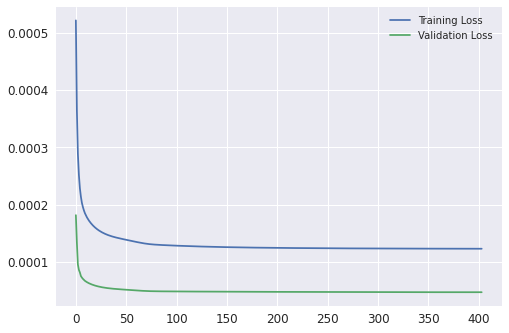

In [80]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [81]:
x_train_pred = history.model.predict(x_train)
x_test_pred = history.model.predict(x_test)
print('train: ',x_train_pred.shape, '\n test: ', x_test_pred.shape)

16/16 [==============================] - 0s 889us/step
train:  (2994, 32) 
 test:  (501, 32)


c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

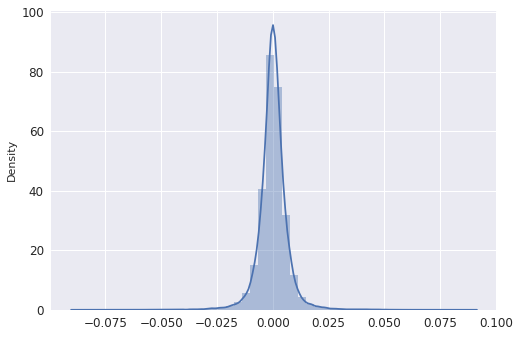

In [82]:
sns.distplot(x_train_pred.reshape(32, 2994))

In [83]:
x_train_pred

array([[ 0.00126511,  0.00188895, -0.00558573, ...,  0.01412038,
        -0.00607364, -0.01101123],
       [-0.00304986,  0.00310841,  0.00403373, ...,  0.00183602,
         0.00994718, -0.00724883],
       [ 0.00405726, -0.00449012,  0.00218518, ..., -0.01044355,
        -0.00081691,  0.00895607],
       ...,
       [-0.00182112,  0.00242627,  0.00109086, ...,  0.00236552,
         0.00205812, -0.0002058 ],
       [ 0.00148086, -0.00343577,  0.00304684, ...,  0.00323258,
         0.00263367, -0.00234762],
       [-0.00257191,  0.00056874,  0.00031489, ...,  0.00500395,
        -0.00063074, -0.00065343]], dtype=float32)

In [107]:
def results_df(output, index, nans=True):
    dct = OrderedDict()
    dct['date'] = index
    for i in range(output.shape[1]):
        # tmp = []
        for j in range(output.shape[0]):
            tmp = []
            tmp.append(output[j][i])
        dct['l'+str(i)] = np.array(tmp)
        del tmp

    if nans:
        df = pd.DataFrame(dct).set_index('date')
    else:
        df = pd.DataFrame(dct).set_index('date').dropna()

    return df

lag_keys = ['l'+str(i) for i in range(32)]

train_pred, test_pred = pd.DataFrame(x_train_pred, columns=lag_keys, index=x_train.index), pd.DataFrame(x_test_pred, columns=lag_keys, index=x_test.index)


# train_pred, test_pred = results_df(x_train_pred, x_train.index), results_df(x_test_pred, x_test.index)


In [108]:
train_pred.head()

,l0,l1,l2,l3,l4,l5,l6,l7,l8,l9,...,l22,l23,l24,l25,l26,l27,l28,l29,l30,l31
date,,,,,,,,,,,,,,,,,,,,,
2008-02-21,0.001265,0.001889,-0.005586,-0.006222,-0.001066,0.001344,0.006425,0.004675,-0.000510,0.007956,...,-0.005354,-0.002396,-0.001817,0.006936,0.005587,-0.007734,0.002859,0.014120,-0.006074,-0.011011
2008-02-22,-0.003050,0.003108,0.004034,-0.008028,-0.006379,-0.000054,0.001105,0.007207,0.001847,-0.001850,...,-0.003357,-0.004973,-0.003044,-0.004961,0.009252,0.008901,-0.007816,0.001836,0.009947,-0.007249
2008-02-25,0.004057,-0.004490,0.002185,0.004144,-0.006556,-0.007652,-0.001742,-0.000430,0.007645,0.002465,...,-0.000451,-0.004567,-0.002962,-0.001896,-0.002775,0.009260,0.006624,-0.010444,-0.000817,0.008956
2008-02-26,0.010289,0.002221,-0.006190,0.002802,0.003562,-0.008816,-0.006831,-0.001606,0.003548,0.007858,...,-0.005709,-0.001654,-0.001925,-0.000870,-0.003833,-0.003502,0.007768,0.006760,-0.004720,-0.001304
2008-02-27,-0.001786,0.009729,0.005408,-0.006817,0.002775,0.002849,-0.010203,-0.004582,-0.000649,0.001795,...,-0.001999,-0.005493,0.000590,-0.005070,-0.002086,-0.002368,-0.003759,0.010188,0.007915,-0.006346


In [86]:
x_train['l0'].max()

0.10682014932976802

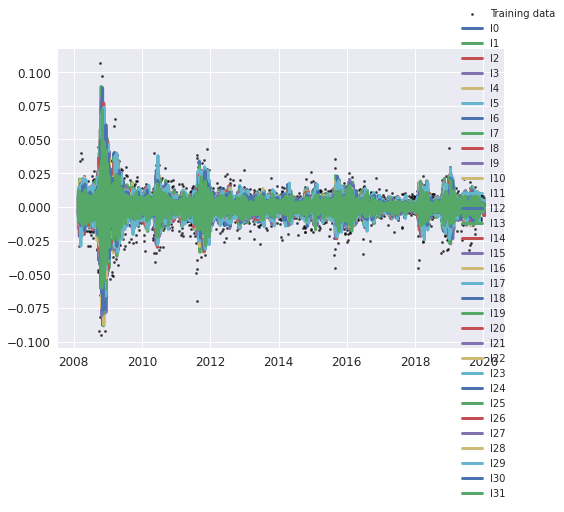

In [109]:
fig, ax = plt.subplots()

ax.scatter(x_train['l0'].index,x_train['l0'], alpha=.8, s=5, color='black', label='Training data')
for i in range(train_pred.shape[1]):
    ax.plot(train_pred['l'+str(i)], label = 'l'+str(i), linewidth=3)
fig.legend()

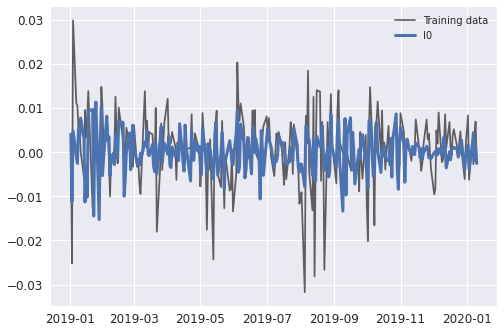

In [110]:
plt.plot(x_train['l0'][x_train.index>'2019-01-01'], alpha=.6, color='black', label='Training data')
plt.plot(train_pred['l0'][train_pred.index>'2019-01-01'], label = 'l0', linewidth=3)
plt.legend()

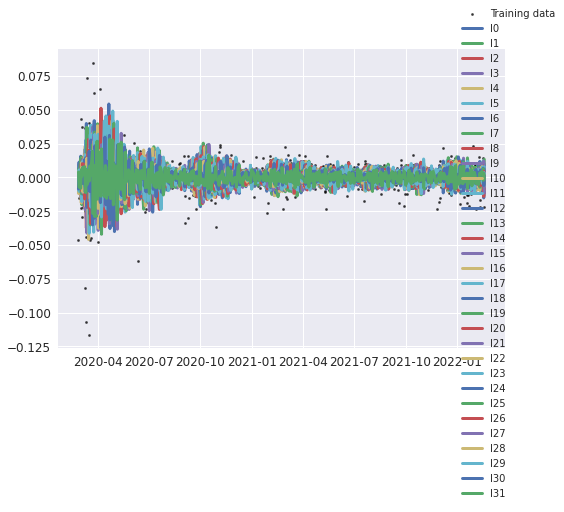

In [114]:
fig, ax = plt.subplots()

ax.scatter(x_test['l0'].index,x_test['l0'], alpha=.8, s=5, color='black', label='Training data')
for i in range(test_pred.shape[1]):
    ax.plot(test_pred['l'+str(i)], label = 'l'+str(i), linewidth=3)
fig.legend()

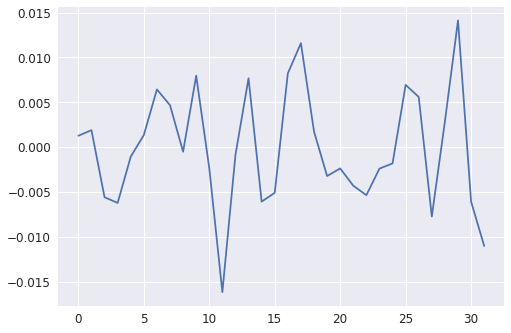

In [111]:
plt.plot(x_train_pred[0])

c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


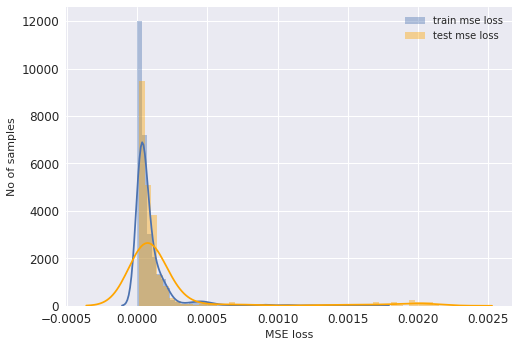

In [122]:
# Get MSE loss.
train_mse_loss = np.mean(np.power(train_pred - x_train, 2), axis=1)
test_mse_loss = np.mean(np.power(test_pred - x_test, 2), axis=1)

sns.distplot(train_mse_loss, bins=50, label='train mse loss')
sns.distplot(test_mse_loss, bins=50, label='test mse loss', color='orange')
plt.xlabel("MSE loss")
plt.ylabel("No of samples")
plt.legend()
plt.show()

# Get reconstruction loss threshold.
# threshold = np.max(train_mae_loss)
# print("Reconstruction error maximum: ", threshold)

c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


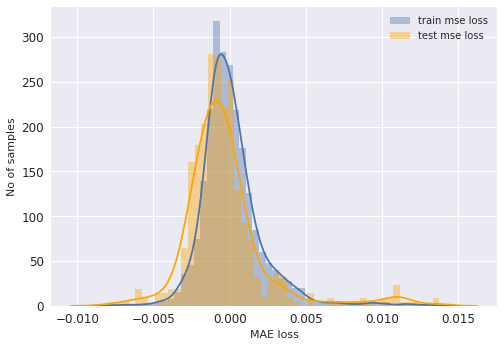

In [123]:
# Get MAE loss.
train_mae_loss = np.mean(train_pred - x_train, axis=1)
test_mae_loss = np.mean(test_pred - x_test, axis=1)

sns.distplot(train_mae_loss, bins=50, label='train mse loss')
sns.distplot(test_mae_loss, bins=50, label='test mse loss', color='orange')
plt.xlabel("MAE loss")
plt.ylabel("No of samples")
plt.legend()
plt.show()

# Get reconstruction loss threshold.
# threshold = np.max(train_mae_loss)
# print("Reconstruction error maximum: ", threshold)

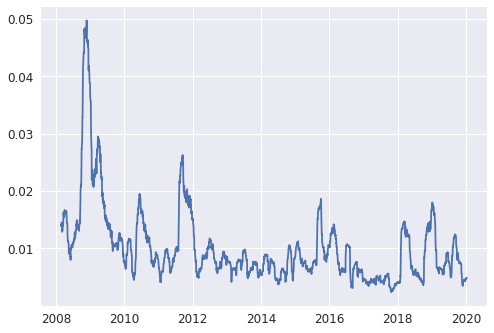

In [113]:
plt.plot(train.rolling(32).std())